**Download dataset from Kaggle**

In [78]:
# from google.colab import files
# files.upload()
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d chrisfilo/urbansound8k
# ! unzip urbansound8k.zip -d UrbanSounds8K

**Inspect the audio files**

In [79]:
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
from IPython.display import Audio
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import pandas as pd

In [80]:
def show_spectrogram(audio):
  # only shows first channel
    spectrogram = torchaudio.transforms.Spectrogram()(audio)[0]
    print("\nShape of spectrogram: {}".format(spectrogram.size()))
    plt.imshow(spectrogram.log2().numpy(), cmap='viridis', origin='lower')
    plt.show()

def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len == max_len):
      return

    elif (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    else:
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    elif (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

**Original Audio**


Shape of spectrogram: torch.Size([201, 576])


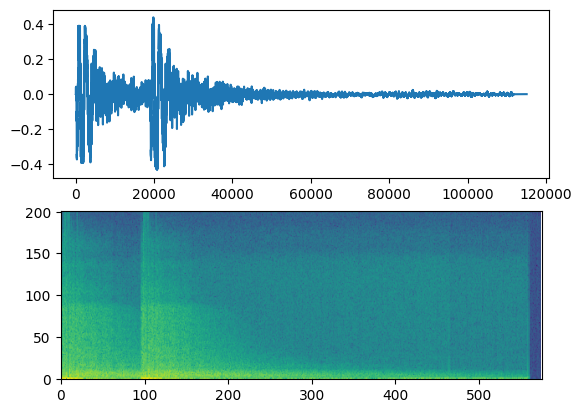

In [81]:
filename = "./UrbanSounds8K/fold1/102305-6-0-0.wav"
waveform, sample_rate = rechannel(torchaudio.load(filename), 1)
fig, axs = plt.subplots(2)
axs[0].plot(waveform.t().numpy())
show_spectrogram(waveform)

**Extended Audio**


Shape of spectrogram: torch.Size([201, 881])


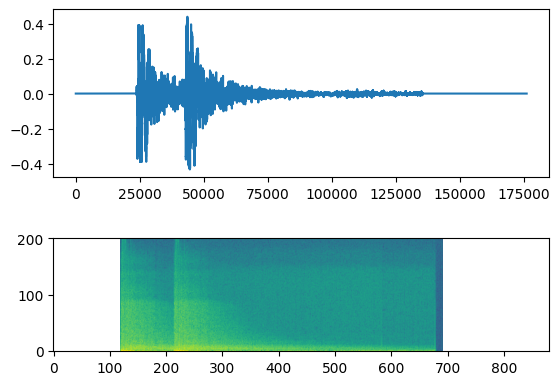

In [82]:
waveform, sr = pad_trunc(rechannel(torchaudio.load(filename),1), 4000)
fig, axs = plt.subplots(2)
axs[0].plot(waveform.t().numpy())
show_spectrogram(waveform)

In [83]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

**Generate Spectrogram**

In [84]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
from PIL import Image

In [85]:
class_map = ['air conditioner', 'car horn', 'children playing', 'dog bark', 'drilling', 'engine idling', 'gunshot', 'jackhammer', 'siren', 'street music']

In [86]:
def load_audio_files(path, dataset):
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        title, _ = os.path.splitext(filename)
        fsID, classID, occurrenceID, sliceID = [int(n) for n in title.split('-')]
        # Load audio
        waveform, sample_rate = pad_trunc(resample(rechannel(torchaudio.load(file_path),1),44100),4000)
        assert waveform.shape == torch.Size([1,176000]), f'Error: waveform shape is {waveform.shape}'
        dataset.append([waveform[0], classID, title])
        
    return dataset

In [87]:
audio_dataset = []

main_path = './UrbanSounds8K/'

dir = [str(p) for p in Path(main_path).glob('fold*')][0:1]

for path in dir:
  audio_dataset = load_audio_files(path, audio_dataset)

print(f"Length of dataset: {len(audio_dataset)}")

Length of dataset: 873


In [88]:
# rm -rf ./UrbanSounds8K/spectrograms/ # remove all spectrograms

In [89]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def create_spectrogram_images(trainloader, train=True):
    length = len(trainloader)
    spectrogram = torchaudio.transforms.Spectrogram()
    timeMask = torchaudio.transforms.TimeMasking(time_mask_param=80, )
    freqMask = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
    num_TimeMask = 4
    num_FreqMask = 4
    num_FreqTimeMask = 4

    for i, data in enumerate(trainloader):
        waveform = data[0]
        classID = data[1].item()
        title = data[2][0]
        if train:
            directory = f'./UrbanSounds8K/spectrograms/train/{class_map[classID]}/'
        else:
            directory = f'./UrbanSounds8K/spectrograms/test/{class_map[classID]}/'
        if(not os.path.isdir(directory)):
            os.makedirs(directory, mode=0o777, exist_ok=True)

        spectrogram_tensor = (spectrogram(waveform) + 1e-12).log2()

        assert spectrogram_tensor.shape == torch.Size([1, 201, 881]), f"Spectrogram size mismatch! {spectrogram_tensor.shape}"
        if train:
            for a in range(num_TimeMask):
                # create transformed waveforms
                masked_spectrogram_tensor = timeMask(spectrogram_tensor)
                np.save(f'{directory}{title}-tm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqMask):
                masked_spectrogram_tensor = freqMask(spectrogram_tensor)
                np.save(f'{directory}{title}-fm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqTimeMask):
                masked_spectrogram_tensor = freqMask(timeMask(spectrogram_tensor))
                np.save(f'{directory}{title}-ftm{a}_spec',
                        masked_spectrogram_tensor.flipud())
        
        np.save(f'{directory}{title}-org_spec', spectrogram_tensor.flipud())
        # break
        if i % 1000 == 0:
            print(f'{i}/{length}')



train_size = int(0.8 * len(audio_dataset))
test_size = len(audio_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    audio_dataset, [train_size, test_size])

audio_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

create_spectrogram_images(audio_dataloader, True)

audio_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

create_spectrogram_images(audio_dataloader, False)

0/698
0/175


Inspect a sample

-39.863136   10.3651


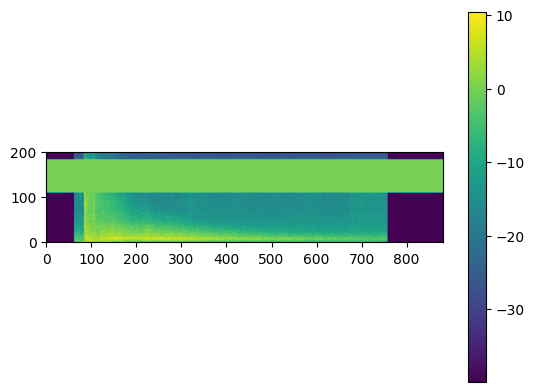

In [91]:
test_load = np.load(
        './UrbanSounds8K/spectrograms/train/gunshot/122690-6-0-0-fm0_spec.npy')
plt.imshow(test_load[0], origin="lower")
plt.colorbar()
print(test_load.min(), " ", test_load.max())

**Actual Machine Learning**

In [92]:
import os
import IPython.display as ipd
from IPython.display import Audio
import random
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
# from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [93]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample


audio_train_dataset = datasets.DatasetFolder(root='./UrbanSounds8K/spectrograms/train/',
                                       loader=npy_loader,
                                       extensions=['.npy'])

audio_test_dataset = datasets.DatasetFolder(root='./UrbanSounds8K/spectrograms/test/',
                                       loader=npy_loader,
                                       extensions=['.npy'])

print("Training size:", len(audio_train_dataset))
print("Testing size:",len(audio_test_dataset))

train_dataloader = torch.utils.data.DataLoader(audio_train_dataset,
                                               batch_size=32,
                                               num_workers=0,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(audio_test_dataset,
                                              batch_size=32,
                                              num_workers=0,
                                              shuffle=True)


Training size: 9074
Testing size: 175


In [94]:
# rm -rf ./logsdir/ # remove all logs

In [95]:
import torch.nn.functional as F
from torch.nn import init

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check that it is on Cuda
next(model.parameters()).device

Using cache found in C:\Users\JianQuan/.cache\torch\hub\pytorch_vision_v0.10.0


device(type='cuda', index=0)

In [122]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function
def train(dataloader, model, optimizer):
    train_size = len(dataloader.dataset)
    batch_size = len(next(iter(dataloader))[1])
    total_batch = len(dataloader)
    train_loss, train_accuracy = 0, 0

    model.train()

    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        batch_loss = cost(pred, Y)
        batch_loss.backward()
        optimizer.step()
        batch_accuracy = (pred.argmax(1)==Y).type(torch.float).sum()
        train_loss += batch_loss.item()
        train_accuracy += batch_accuracy.item()
        if batch % 10 == 0:
            print(
                f"Training batch {batch}/{total_batch} -> Loss: {batch_loss.item()}  Accuracy: {batch_accuracy.item()/batch_size}%"
            )
    train_loss /= train_size
    train_accuracy /= train_size/100
    return(train_loss, train_accuracy)


# Create the validation/test function
def test(dataloader, model):
    test_size = len(dataloader.dataset)
    total_batch = len(dataloader)
    test_loss, test_accuracy = 0, 0

    model.eval()

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            batch_loss = cost(pred, Y)
            batch_accuracy = (pred.argmax(1)==Y).type(torch.float).sum()
            test_loss += batch_loss.item()
            test_accuracy += batch_accuracy.item()
        if batch % 10 == 0:
            print(
                f"Testing batch {batch}/{total_batch} -> Loss: {batch_loss.item()}  Accuracy: {batch_accuracy.item()/batch_size}%"
            )

    test_loss /= test_size
    test_accuracy /= test_size/100
    return(test_loss, test_accuracy)

Tensorboard model graph

In [102]:
import time
from datetime import datetime

title = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")

# title="freqTimeFulldataset"

first_batch = next(iter(train_dataloader))
writer = SummaryWriter(f'./logs/{title}')
writer.add_graph(model, first_batch[0].to(device))
writer.close()

In [103]:
def tensorBoardLogging(train_loss, train_accuracy, test_loss, test_accuracy, epoch):
    writer.add_scalar('1 Training/1 Model loss', train_loss, epoch)
    writer.add_scalar('1 Training/2 Model accuracy', train_accuracy, epoch)
    writer.add_scalar('2 Testing/1 Model loss', test_loss, epoch)
    writer.add_scalar('2 Testing/2 Model accuracy', test_accuracy, epoch)
    writer.close()

In [123]:
import time

epochs = 20

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}\n-------------------------------')
    start = time.time()
    train_loss, train_accuracy = train(train_dataloader, model, optimizer)
    test_loss, test_accuracy = test(test_dataloader, model)    
    end = time.time()
    print(f"\nEpoch duration: {end - start} seconds")
    print(f'Training | Loss: {train_loss} Accuracy: {train_accuracy}%')
    print(f'Testing  | Loss: {test_loss} Accuracy: {test_accuracy}% \n')    
    tensorBoardLogging(train_loss, train_accuracy, test_loss, test_accuracy, epoch)

print('Done!')

Epoch 1/20
-------------------------------
Training batch 0/284 -> Loss: 0.44080716371536255  Accuracy: 0.8125%


KeyboardInterrupt: 

**Testing**

**Debugging**

In [ ]:
# audio_dataset = []
# sum = 0

# main_path = './UrbanSounds8K/spectrograms/'

# dir = [str(p) for p in Path(main_path).glob('*')]
# for path in dir:
#   print('Loading: '+ path)
#   num = len([str(p) for p in Path(path).glob('*')])
#   sum += num
#   print(num)

# sum